In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
df_raw = pd.read_csv("wdbc.csv", header=None)

df_raw

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
device = "cpu"

In [4]:
y = pd.get_dummies(df_raw.iloc[:,1:2])

y = torch.Tensor(y.values).to(device)

y

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [1., 0.]])

In [5]:
x = df_raw.iloc[:,2:]

x = (x - x.min()) / (x.max() - x.min())

x = torch.Tensor(x.values).to(device)

x

tensor([[0.5210, 0.0227, 0.5460,  ..., 0.9120, 0.5985, 0.4189],
        [0.6431, 0.2726, 0.6158,  ..., 0.6392, 0.2336, 0.2229],
        [0.6015, 0.3903, 0.5957,  ..., 0.8351, 0.4037, 0.2134],
        ...,
        [0.4553, 0.6212, 0.4458,  ..., 0.4873, 0.1287, 0.1519],
        [0.6446, 0.6635, 0.6655,  ..., 0.9107, 0.4971, 0.4523],
        [0.0369, 0.5015, 0.0285,  ..., 0.0000, 0.2574, 0.1007]])

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 10000) # input to first hidden layer
        self.hidden_layer_2 = nn.Linear(10000, 10)
        
        self.multiple_layers = nn.Sequential(
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
        )
        
        self.output_layer = nn.Linear(10, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.hidden_layer_2(x)
        x = self.activation(x)
        
        x = self.multiple_layers(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [7]:
model = NeuralNetwork(30, 2).to(device)

# Test structure of model
predictions = model.forward(x)

predictions

tensor([[0.6175, 0.6310],
        [0.6175, 0.6310],
        [0.6175, 0.6310],
        ...,
        [0.6175, 0.6310],
        [0.6175, 0.6310],
        [0.6175, 0.6310]], grad_fn=<SigmoidBackward0>)

In [8]:
learning_rate = 0.00001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [9]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [10]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset(x=x, y=y)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 1000
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "model.pth")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.49it/s, loss=0.262]


Ave Loss: 0.26703398452516186
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.37it/s, loss=0.262]


Ave Loss: 0.2666268806185639
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.79it/s, loss=0.262]


Ave Loss: 0.2662408686520761
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.94it/s, loss=0.262]


Ave Loss: 0.265861694488609
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.43it/s, loss=0.263]


Ave Loss: 0.2654879600332494
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.83it/s, loss=0.263]


Ave Loss: 0.26511912910561813
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.51it/s, loss=0.263]


Ave Loss: 0.2647548903498733
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.42it/s, loss=0.263]


Ave Loss: 0.26439505737078817
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.70it/s, loss=0.263]


Ave Loss: 0.264039476189697
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 197.94it/s, loss=0.263]


Ave Loss: 0.2636880464198297
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 195.28it/s, loss=0.263]


Ave Loss: 0.2633406606159712
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.51it/s, loss=0.263]


Ave Loss: 0.2629972400895336
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.53it/s, loss=0.263]


Ave Loss: 0.2626576959563975
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 195.52it/s, loss=0.264]


Ave Loss: 0.2623219761932105
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 144.33it/s, loss=0.264]


Ave Loss: 0.26199000028141756
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 151.98it/s, loss=0.264]


Ave Loss: 0.26166171828905743
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 166.01it/s, loss=0.264]


Ave Loss: 0.26133706120022554
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.30it/s, loss=0.264]


Ave Loss: 0.26101597463875487
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 140.53it/s, loss=0.264]


Ave Loss: 0.26069841468543337
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 172.26it/s, loss=0.264]


Ave Loss: 0.2603843170299865
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.09it/s, loss=0.265]


Ave Loss: 0.2600736408902888
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 164.36it/s, loss=0.265]


Ave Loss: 0.2597663339815642
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 164.83it/s, loss=0.265]


Ave Loss: 0.2594623437576127
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.62it/s, loss=0.265]


Ave Loss: 0.2591616412003835
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.23it/s, loss=0.265]


Ave Loss: 0.25886415990821104
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.72it/s, loss=0.265]


Ave Loss: 0.25856987243158774
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.98it/s, loss=0.265]


Ave Loss: 0.2582787353741495
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.11it/s, loss=0.266]


Ave Loss: 0.2579907029867172
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 174.00it/s, loss=0.266]


Ave Loss: 0.25770574455198486
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.76it/s, loss=0.266]


Ave Loss: 0.2574238259541361
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.82it/s, loss=0.266]


Ave Loss: 0.257144907456741
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.02it/s, loss=0.266]


Ave Loss: 0.2568689482776742
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 146.81it/s, loss=0.266]


Ave Loss: 0.2565959301172641
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 145.85it/s, loss=0.267]


Ave Loss: 0.2563258179447107
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 154.69it/s, loss=0.267]


Ave Loss: 0.2560585828726752
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 155.08it/s, loss=0.267]


Ave Loss: 0.2557941839883202
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 158.81it/s, loss=0.267]


Ave Loss: 0.2555325961949533
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.02it/s, loss=0.267]


Ave Loss: 0.2552738051142609
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.39it/s, loss=0.267]


Ave Loss: 0.2550177648663521
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 170.91it/s, loss=0.268]


Ave Loss: 0.2547644581972507
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.77it/s, loss=0.268]


Ave Loss: 0.25451385164470003
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 139.89it/s, loss=0.268]


Ave Loss: 0.2542659241640777
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 137.89it/s, loss=0.268]


Ave Loss: 0.2540206498744195
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 153.06it/s, loss=0.268]


Ave Loss: 0.25377800563971203
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.63it/s, loss=0.268]


Ave Loss: 0.25353795943552987
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 143.45it/s, loss=0.269]


Ave Loss: 0.25330048838728353
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.03it/s, loss=0.269]


Ave Loss: 0.25306556360763416
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.26it/s, loss=0.269]


Ave Loss: 0.25283316496694297
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.96it/s, loss=0.269]


Ave Loss: 0.2526032708977398
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.09it/s, loss=0.269]


Ave Loss: 0.2523758568261799
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 195.33it/s, loss=0.269]


Ave Loss: 0.25215089974696175
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.14it/s, loss=0.27]


Ave Loss: 0.25192837299484955
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.45it/s, loss=0.27]


Ave Loss: 0.2517082519959985
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.42it/s, loss=0.27]


Ave Loss: 0.25149052263351906
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.72it/s, loss=0.27]


Ave Loss: 0.251275161509974
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.78it/s, loss=0.27]


Ave Loss: 0.25106214797287657
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.10it/s, loss=0.271]


Ave Loss: 0.2508514581019418
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.87it/s, loss=0.271]


Ave Loss: 0.2506430620948474
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 144.00it/s, loss=0.271]


Ave Loss: 0.2504369582523379
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 163.81it/s, loss=0.271]


Ave Loss: 0.2502331114129016
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 167.93it/s, loss=0.271]


Ave Loss: 0.2500315079824966
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.22it/s, loss=0.272]


Ave Loss: 0.24983211933520802
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.77it/s, loss=0.272]


Ave Loss: 0.24963493880472684
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.33it/s, loss=0.272]


Ave Loss: 0.24943994508500686
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.81it/s, loss=0.272]


Ave Loss: 0.24924710758945398
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.40it/s, loss=0.272]


Ave Loss: 0.24905641821392796
Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.02it/s, loss=0.273]


Ave Loss: 0.248867856698078
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.92it/s, loss=0.273]


Ave Loss: 0.24868139559239671
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.26it/s, loss=0.273]


Ave Loss: 0.24849702705416762
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.11it/s, loss=0.273]


Ave Loss: 0.2483147282088012
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.38it/s, loss=0.273]


Ave Loss: 0.248134484677984
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 201.69it/s, loss=0.274]


Ave Loss: 0.24795627188787125
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 198.31it/s, loss=0.274]


Ave Loss: 0.247780065656754
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.55it/s, loss=0.274]


Ave Loss: 0.24760586219398598
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.10it/s, loss=0.274]


Ave Loss: 0.2474336271223269
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.81it/s, loss=0.274]


Ave Loss: 0.24726333024731853
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.31it/s, loss=0.275]


Ave Loss: 0.24709463184862807
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.45it/s, loss=0.275]


Ave Loss: 0.24692743716009877
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.82it/s, loss=0.275]


Ave Loss: 0.2467627752768366
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.11it/s, loss=0.275]


Ave Loss: 0.246600056295855
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.75it/s, loss=0.275]


Ave Loss: 0.246439227670954
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.18it/s, loss=0.276]


Ave Loss: 0.24628027201744548
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 174.95it/s, loss=0.276]


Ave Loss: 0.24612316724501157
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.50it/s, loss=0.276]


Ave Loss: 0.24596789466184482
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.35it/s, loss=0.276]


Ave Loss: 0.24581443204691536
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.11it/s, loss=0.276]


Ave Loss: 0.24566275861702466
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.06it/s, loss=0.277]


Ave Loss: 0.24551287437217278
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.67it/s, loss=0.277]


Ave Loss: 0.24536474585010296
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.72it/s, loss=0.277]


Ave Loss: 0.24521836024104504
Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 161.54it/s, loss=0.277]


Ave Loss: 0.24507369636966472
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.18it/s, loss=0.278]


Ave Loss: 0.24493075175243512
Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.54it/s, loss=0.278]


Ave Loss: 0.2447895015540876
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.63it/s, loss=0.278]


Ave Loss: 0.24464993440268332
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 198.29it/s, loss=0.278]


Ave Loss: 0.2445120275543447
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.18it/s, loss=0.278]


Ave Loss: 0.24437577055211654
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.61it/s, loss=0.279]


Ave Loss: 0.24424114248208834
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.94it/s, loss=0.279]


Ave Loss: 0.24410813079591384
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.42it/s, loss=0.279]


Ave Loss: 0.2439767226838229
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.13it/s, loss=0.279]


Ave Loss: 0.24384689683976926
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.70it/s, loss=0.279]


Ave Loss: 0.24371864712029173
Epoch: 100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.51it/s, loss=0.28]


Ave Loss: 0.2435919511736485
Epoch: 101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.41it/s, loss=0.28]


Ave Loss: 0.24346679331440674
Epoch: 102


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.99it/s, loss=0.28]


Ave Loss: 0.24334316151706795
Epoch: 103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 204.17it/s, loss=0.28]


Ave Loss: 0.2432210433639978
Epoch: 104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 240.17it/s, loss=0.28]


Ave Loss: 0.24310041950982914
Epoch: 105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.57it/s, loss=0.281]


Ave Loss: 0.2429812749226888
Epoch: 106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.99it/s, loss=0.281]


Ave Loss: 0.24286360476623503
Epoch: 107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 205.39it/s, loss=0.281]


Ave Loss: 0.2427473805452648
Epoch: 108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 209.45it/s, loss=0.281]


Ave Loss: 0.24263259676987664
Epoch: 109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.05it/s, loss=0.282]


Ave Loss: 0.2425192301733452
Epoch: 110


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 209.05it/s, loss=0.282]


Ave Loss: 0.2424072789257033
Epoch: 111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.09it/s, loss=0.282]


Ave Loss: 0.24229672564226284
Epoch: 112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.84it/s, loss=0.282]


Ave Loss: 0.24218755333047165
Epoch: 113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.15it/s, loss=0.282]


Ave Loss: 0.2420797413378431
Epoch: 114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.74it/s, loss=0.283]


Ave Loss: 0.24197329162505635
Epoch: 115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.00it/s, loss=0.283]


Ave Loss: 0.24186817778829942
Epoch: 116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.54it/s, loss=0.283]


Ave Loss: 0.24176438427285143
Epoch: 117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.62it/s, loss=0.283]


Ave Loss: 0.24166191513078256
Epoch: 118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.34it/s, loss=0.283]


Ave Loss: 0.2415607410826181
Epoch: 119


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 201.14it/s, loss=0.284]


Ave Loss: 0.24146085559276112
Epoch: 120


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.01it/s, loss=0.284]


Ave Loss: 0.24136224258364292
Epoch: 121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.26it/s, loss=0.284]


Ave Loss: 0.24126489185973218
Epoch: 122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.88it/s, loss=0.284]


Ave Loss: 0.2411687876048841
Epoch: 123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 213.74it/s, loss=0.284]


Ave Loss: 0.24107391583292107
Epoch: 124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.12it/s, loss=0.285]


Ave Loss: 0.24098026713258341
Epoch: 125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.45it/s, loss=0.285]


Ave Loss: 0.24088782346562335
Epoch: 126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 164.19it/s, loss=0.285]


Ave Loss: 0.24079657829644388
Epoch: 127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 197.04it/s, loss=0.285]


Ave Loss: 0.2407065109725584
Epoch: 128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 173.09it/s, loss=0.285]


Ave Loss: 0.2406176154812177
Epoch: 129


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 203.31it/s, loss=0.286]


Ave Loss: 0.24052986868640833
Epoch: 130


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.63it/s, loss=0.286]


Ave Loss: 0.2404432664053482
Epoch: 131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 209.07it/s, loss=0.286]


Ave Loss: 0.24035778929267013
Epoch: 132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 209.27it/s, loss=0.286]


Ave Loss: 0.24027342349290848
Epoch: 133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.06it/s, loss=0.286]


Ave Loss: 0.24019015946409158
Epoch: 134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 213.85it/s, loss=0.287]


Ave Loss: 0.24010798034437916
Epoch: 135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.98it/s, loss=0.287]


Ave Loss: 0.2400268718861697
Epoch: 136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.05it/s, loss=0.287]


Ave Loss: 0.23994682193325276
Epoch: 137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.89it/s, loss=0.287]


Ave Loss: 0.23986781388521194
Epoch: 138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.21it/s, loss=0.287]


Ave Loss: 0.2397898418600099
Epoch: 139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.39it/s, loss=0.288]


Ave Loss: 0.2397128760553243
Epoch: 140


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.00it/s, loss=0.288]


Ave Loss: 0.23963691960824163
Epoch: 141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.46it/s, loss=0.288]


Ave Loss: 0.23956195265054703
Epoch: 142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.60it/s, loss=0.288]


Ave Loss: 0.2394879558368733
Epoch: 143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.74it/s, loss=0.288]


Ave Loss: 0.23941493138932346
Epoch: 144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.35it/s, loss=0.289]


Ave Loss: 0.23934286375317657
Epoch: 145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.29it/s, loss=0.289]


Ave Loss: 0.2392717329295058
Epoch: 146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.72it/s, loss=0.289]


Ave Loss: 0.23920152427857383
Epoch: 147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.31it/s, loss=0.289]


Ave Loss: 0.2391322411988911
Epoch: 148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.87it/s, loss=0.289]


Ave Loss: 0.2390638593780367
Epoch: 149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.80it/s, loss=0.29]


Ave Loss: 0.2389963705811584
Epoch: 150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.26it/s, loss=0.29]


Ave Loss: 0.23892977258615328
Epoch: 151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.58it/s, loss=0.29]


Ave Loss: 0.23886404121131227
Epoch: 152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.97it/s, loss=0.29]


Ave Loss: 0.23879916691466382
Epoch: 153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.63it/s, loss=0.29]


Ave Loss: 0.2387351442063064
Epoch: 154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.22it/s, loss=0.291]


Ave Loss: 0.2386719713869848
Epoch: 155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.50it/s, loss=0.291]


Ave Loss: 0.23860962218359896
Epoch: 156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.36it/s, loss=0.291]


Ave Loss: 0.23854808391709076
Epoch: 157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.59it/s, loss=0.291]


Ave Loss: 0.23848736626014375
Epoch: 158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.50it/s, loss=0.291]


Ave Loss: 0.23842744385464149
Epoch: 159


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.30it/s, loss=0.292]


Ave Loss: 0.23836830101515116
Epoch: 160


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.29it/s, loss=0.292]


Ave Loss: 0.23830995172785038
Epoch: 161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.00it/s, loss=0.292]


Ave Loss: 0.23825236579828096
Epoch: 162


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.22it/s, loss=0.292]


Ave Loss: 0.23819554165789955
Epoch: 163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.86it/s, loss=0.292]


Ave Loss: 0.23813946453625695
Epoch: 164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.54it/s, loss=0.293]


Ave Loss: 0.23808412881273971
Epoch: 165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.58it/s, loss=0.293]


Ave Loss: 0.23802952233113742
Epoch: 166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.97it/s, loss=0.293]


Ave Loss: 0.23797564300005897
Epoch: 167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.98it/s, loss=0.293]


Ave Loss: 0.2379224717355611
Epoch: 168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.59it/s, loss=0.293]


Ave Loss: 0.23787000435486175
Epoch: 169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.16it/s, loss=0.293]


Ave Loss: 0.2378182334073803
Epoch: 170


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.36it/s, loss=0.294]


Ave Loss: 0.2377671445148033
Epoch: 171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.60it/s, loss=0.294]


Ave Loss: 0.23771673427862033
Epoch: 172


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.21it/s, loss=0.294]


Ave Loss: 0.23766699564038662
Epoch: 173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.25it/s, loss=0.294]


Ave Loss: 0.23761791748958722
Epoch: 174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.26it/s, loss=0.294]


Ave Loss: 0.2375694854479087
Epoch: 175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.62it/s, loss=0.295]


Ave Loss: 0.23752169494043318
Epoch: 176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.00it/s, loss=0.295]


Ave Loss: 0.23747454021583525
Epoch: 177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.66it/s, loss=0.295]


Ave Loss: 0.23742801486922985
Epoch: 178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.13it/s, loss=0.295]


Ave Loss: 0.23738210360731996
Epoch: 179


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.48it/s, loss=0.295]


Ave Loss: 0.2373368002866444
Epoch: 180


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.91it/s, loss=0.295]


Ave Loss: 0.2372921028158121
Epoch: 181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.66it/s, loss=0.296]


Ave Loss: 0.2372479914573201
Epoch: 182


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.63it/s, loss=0.296]


Ave Loss: 0.23720447810595496
Epoch: 183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.25it/s, loss=0.296]


Ave Loss: 0.23716153988712713
Epoch: 184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.55it/s, loss=0.296]


Ave Loss: 0.2371191686966963
Epoch: 185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.79it/s, loss=0.296]


Ave Loss: 0.23707736048259234
Epoch: 186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.04it/s, loss=0.296]


Ave Loss: 0.23703611014704956
Epoch: 187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.25it/s, loss=0.297]


Ave Loss: 0.23699541324586199
Epoch: 188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.05it/s, loss=0.297]


Ave Loss: 0.23695525357074904
Epoch: 189


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.08it/s, loss=0.297]


Ave Loss: 0.2369156300760152
Epoch: 190


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.27it/s, loss=0.297]


Ave Loss: 0.2368765345268082
Epoch: 191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.30it/s, loss=0.297]


Ave Loss: 0.2368379552897654
Epoch: 192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.48it/s, loss=0.298]


Ave Loss: 0.2367999008611629
Epoch: 193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.22it/s, loss=0.298]


Ave Loss: 0.2367623466671559
Epoch: 194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.18it/s, loss=0.298]


Ave Loss: 0.23672529100848919
Epoch: 195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.40it/s, loss=0.298]


Ave Loss: 0.23668873414658664
Epoch: 196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.33it/s, loss=0.298]


Ave Loss: 0.2366526632716781
Epoch: 197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.03it/s, loss=0.298]


Ave Loss: 0.23661707289386213
Epoch: 198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.94it/s, loss=0.299]


Ave Loss: 0.23658195517042227
Epoch: 199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.41it/s, loss=0.299]


Ave Loss: 0.23654730565715254
Epoch: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.45it/s, loss=0.299]


Ave Loss: 0.23651311102143505
Epoch: 201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.38it/s, loss=0.299]


Ave Loss: 0.2364793819816489
Epoch: 202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.23it/s, loss=0.299]


Ave Loss: 0.23644609344110154
Epoch: 203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.10it/s, loss=0.299]


Ave Loss: 0.23641325010542283
Epoch: 204


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.29it/s, loss=0.3]


Ave Loss: 0.2363808425633531
Epoch: 205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.04it/s, loss=0.3]


Ave Loss: 0.23634886166505648
Epoch: 206


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.76it/s, loss=0.3]


Ave Loss: 0.23631730375059865
Epoch: 207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.78it/s, loss=0.3]


Ave Loss: 0.23628616764357216
Epoch: 208


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.88it/s, loss=0.3]


Ave Loss: 0.23625543961922327
Epoch: 209


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.16it/s, loss=0.3]


Ave Loss: 0.23622512111538335
Epoch: 210


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.64it/s, loss=0.3]


Ave Loss: 0.23619520742642253
Epoch: 211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.36it/s, loss=0.301]


Ave Loss: 0.236165682736196
Epoch: 212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.10it/s, loss=0.301]


Ave Loss: 0.23613654835182324
Epoch: 213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.48it/s, loss=0.301]


Ave Loss: 0.2361077998290982
Epoch: 214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.36it/s, loss=0.301]


Ave Loss: 0.23607942893316872
Epoch: 215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.27it/s, loss=0.301]


Ave Loss: 0.23605143710186607
Epoch: 216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.16it/s, loss=0.301]


Ave Loss: 0.23602381309396342
Epoch: 217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.27it/s, loss=0.302]


Ave Loss: 0.23599655141955928
Epoch: 218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.89it/s, loss=0.302]


Ave Loss: 0.23596964567376857
Epoch: 219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.34it/s, loss=0.302]


Ave Loss: 0.23594310200005247
Epoch: 220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 213.59it/s, loss=0.302]


Ave Loss: 0.2359169041901304
Epoch: 221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.76it/s, loss=0.302]


Ave Loss: 0.23589105185186654
Epoch: 222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.76it/s, loss=0.302]


Ave Loss: 0.23586553505115343
Epoch: 223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.74it/s, loss=0.302]


Ave Loss: 0.23584036398352237
Epoch: 224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.43it/s, loss=0.303]


Ave Loss: 0.23581551172231374
Epoch: 225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.28it/s, loss=0.303]


Ave Loss: 0.23579099931214986
Epoch: 226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.63it/s, loss=0.303]


Ave Loss: 0.2357668023098979
Epoch: 227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.53it/s, loss=0.303]


Ave Loss: 0.23574292725115492
Epoch: 228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.51it/s, loss=0.303]


Ave Loss: 0.23571935923475967
Epoch: 229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.70it/s, loss=0.303]


Ave Loss: 0.23569611224688983
Epoch: 230


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.14it/s, loss=0.304]


Ave Loss: 0.23567316197512442
Epoch: 231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.73it/s, loss=0.304]


Ave Loss: 0.23565051142583815
Epoch: 232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.27it/s, loss=0.304]


Ave Loss: 0.2356281676574757
Epoch: 233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.51it/s, loss=0.304]


Ave Loss: 0.23560611080182225
Epoch: 234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.14it/s, loss=0.304]


Ave Loss: 0.23558435000871358
Epoch: 235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.85it/s, loss=0.304]


Ave Loss: 0.23556286828559742
Epoch: 236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.92it/s, loss=0.304]


Ave Loss: 0.23554167164522305
Epoch: 237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.55it/s, loss=0.305]


Ave Loss: 0.2355207510684666
Epoch: 238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.78it/s, loss=0.305]


Ave Loss: 0.23550010668603996
Epoch: 239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.35it/s, loss=0.305]


Ave Loss: 0.23547973091665067
Epoch: 240


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.44it/s, loss=0.305]


Ave Loss: 0.23545962859664046
Epoch: 241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.03it/s, loss=0.305]


Ave Loss: 0.2354397878312228
Epoch: 242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.68it/s, loss=0.305]


Ave Loss: 0.23542020796683796
Epoch: 243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.94it/s, loss=0.305]


Ave Loss: 0.23540088142219343
Epoch: 244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.75it/s, loss=0.305]


Ave Loss: 0.2353818072823056
Epoch: 245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.29it/s, loss=0.306]


Ave Loss: 0.23536299116778792
Epoch: 246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.92it/s, loss=0.306]


Ave Loss: 0.23534441412540905
Epoch: 247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.81it/s, loss=0.306]


Ave Loss: 0.23532608935707494
Epoch: 248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.20it/s, loss=0.306]


Ave Loss: 0.2353079967331468
Epoch: 249


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.51it/s, loss=0.306]


Ave Loss: 0.23529014671057985
Epoch: 250


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.79it/s, loss=0.306]


Ave Loss: 0.23527252765601142
Epoch: 251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 213.90it/s, loss=0.306]


Ave Loss: 0.2352551390465937
Epoch: 252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.18it/s, loss=0.307]


Ave Loss: 0.235237982581582
Epoch: 253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.75it/s, loss=0.307]


Ave Loss: 0.2352210484575807
Epoch: 254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.23it/s, loss=0.307]


Ave Loss: 0.23520433419106299
Epoch: 255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.77it/s, loss=0.307]


Ave Loss: 0.2351878427884035
Epoch: 256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.36it/s, loss=0.307]


Ave Loss: 0.2351715709818037
Epoch: 257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.97it/s, loss=0.307]


Ave Loss: 0.23515550491579792
Epoch: 258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.49it/s, loss=0.307]


Ave Loss: 0.23513965740015633
Epoch: 259


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.09it/s, loss=0.307]


Ave Loss: 0.23512401052734308
Epoch: 260


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.52it/s, loss=0.308]


Ave Loss: 0.2351085704408194
Epoch: 261


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.45it/s, loss=0.308]


Ave Loss: 0.2350933330885151
Epoch: 262


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.09it/s, loss=0.308]


Ave Loss: 0.23507829742473468
Epoch: 263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.36it/s, loss=0.308]


Ave Loss: 0.23506346083523935
Epoch: 264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.38it/s, loss=0.308]


Ave Loss: 0.23504881809155145
Epoch: 265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 195.59it/s, loss=0.308]


Ave Loss: 0.2350343642266173
Epoch: 266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.62it/s, loss=0.308]


Ave Loss: 0.2350201009396921
Epoch: 267


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.13it/s, loss=0.308]


Ave Loss: 0.23500602417870572
Epoch: 268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 198.13it/s, loss=0.309]


Ave Loss: 0.23499213368223423
Epoch: 269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 200.65it/s, loss=0.309]


Ave Loss: 0.23497842513678366
Epoch: 270


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.24it/s, loss=0.309]


Ave Loss: 0.23496489383672414
Epoch: 271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 205.29it/s, loss=0.309]


Ave Loss: 0.23495154135059892
Epoch: 272


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.17it/s, loss=0.309]


Ave Loss: 0.23493836676342444
Epoch: 273


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.53it/s, loss=0.309]


Ave Loss: 0.23492535974895745
Epoch: 274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.62it/s, loss=0.309]


Ave Loss: 0.23491252945703373
Epoch: 275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.41it/s, loss=0.309]


Ave Loss: 0.23489986242432342
Epoch: 276


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.78it/s, loss=0.31]


Ave Loss: 0.23488736374859223
Epoch: 277


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.92it/s, loss=0.31]


Ave Loss: 0.23487503120773717
Epoch: 278


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.11it/s, loss=0.31]


Ave Loss: 0.23486285408337912
Epoch: 279


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.94it/s, loss=0.31]


Ave Loss: 0.2348508425710494
Epoch: 280


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.15it/s, loss=0.31]


Ave Loss: 0.23483898529880926
Epoch: 281


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.15it/s, loss=0.31]


Ave Loss: 0.23482729102435865
Epoch: 282


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.25it/s, loss=0.31]


Ave Loss: 0.23481574066375432
Epoch: 283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.60it/s, loss=0.31]


Ave Loss: 0.23480435134026043
Epoch: 284


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.41it/s, loss=0.31]


Ave Loss: 0.23479310266281428
Epoch: 285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.27it/s, loss=0.311]


Ave Loss: 0.23478200012131742
Epoch: 286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.66it/s, loss=0.311]


Ave Loss: 0.2347710518199101
Epoch: 287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.04it/s, loss=0.311]


Ave Loss: 0.23476024102746396
Epoch: 288


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.61it/s, loss=0.311]


Ave Loss: 0.2347495712732014
Epoch: 289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.20it/s, loss=0.311]


Ave Loss: 0.23473904634776868
Epoch: 290


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.31it/s, loss=0.311]


Ave Loss: 0.23472866076126433
Epoch: 291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.42it/s, loss=0.311]


Ave Loss: 0.23471840784737938
Epoch: 292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.52it/s, loss=0.311]


Ave Loss: 0.23470829283459144
Epoch: 293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.20it/s, loss=0.311]


Ave Loss: 0.2346983120629662
Epoch: 294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.51it/s, loss=0.312]


Ave Loss: 0.23468845350700512
Epoch: 295


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.59it/s, loss=0.312]


Ave Loss: 0.2346787345513963
Epoch: 296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.14it/s, loss=0.312]


Ave Loss: 0.23466913951070686
Epoch: 297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.68it/s, loss=0.312]


Ave Loss: 0.2346596719141592
Epoch: 298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.49it/s, loss=0.312]


Ave Loss: 0.23465032601042798
Epoch: 299


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.25it/s, loss=0.312]


Ave Loss: 0.23464110650514303
Epoch: 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.44it/s, loss=0.312]


Ave Loss: 0.23463200529416403
Epoch: 301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.35it/s, loss=0.312]


Ave Loss: 0.23462302054752382
Epoch: 302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.95it/s, loss=0.312]


Ave Loss: 0.23461416089221052
Epoch: 303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.51it/s, loss=0.312]


Ave Loss: 0.23460541600198076
Epoch: 304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.98it/s, loss=0.313]


Ave Loss: 0.2345967891446331
Epoch: 305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.96it/s, loss=0.313]


Ave Loss: 0.2345882659418541
Epoch: 306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.85it/s, loss=0.313]


Ave Loss: 0.23457986613114676
Epoch: 307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.98it/s, loss=0.313]


Ave Loss: 0.23457157363494238
Epoch: 308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.47it/s, loss=0.313]


Ave Loss: 0.2345633921131753
Epoch: 309


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.30it/s, loss=0.313]


Ave Loss: 0.23455531306956945
Epoch: 310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 230.89it/s, loss=0.313]


Ave Loss: 0.23454734970603072
Epoch: 311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.16it/s, loss=0.313]


Ave Loss: 0.23453948476858305
Epoch: 312


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.13it/s, loss=0.313]


Ave Loss: 0.2345317294984533
Epoch: 313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.55it/s, loss=0.313]


Ave Loss: 0.2345240706937355
Epoch: 314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.60it/s, loss=0.314]


Ave Loss: 0.23451651436717888
Epoch: 315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.39it/s, loss=0.314]


Ave Loss: 0.23450905542101777
Epoch: 316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.62it/s, loss=0.314]


Ave Loss: 0.23450169607735516
Epoch: 317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.17it/s, loss=0.314]


Ave Loss: 0.2344944341140881
Epoch: 318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.78it/s, loss=0.314]


Ave Loss: 0.2344872726683031
Epoch: 319


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.06it/s, loss=0.314]


Ave Loss: 0.23448020023734947
Epoch: 320


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.39it/s, loss=0.314]


Ave Loss: 0.23447321812834657
Epoch: 321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.88it/s, loss=0.314]


Ave Loss: 0.23446633392258695
Epoch: 322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.86it/s, loss=0.314]


Ave Loss: 0.23445954396013627
Epoch: 323


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.39it/s, loss=0.314]


Ave Loss: 0.23445283425481697
Epoch: 324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.37it/s, loss=0.314]


Ave Loss: 0.2344462220606051
Epoch: 325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.25it/s, loss=0.315]


Ave Loss: 0.23443969417559474
Epoch: 326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.30it/s, loss=0.315]


Ave Loss: 0.23443325321402467
Epoch: 327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.07it/s, loss=0.315]


Ave Loss: 0.23442689237887399
Epoch: 328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.08it/s, loss=0.315]


Ave Loss: 0.2344206141536696
Epoch: 329


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.62it/s, loss=0.315]


Ave Loss: 0.23441442350546518
Epoch: 330


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.71it/s, loss=0.315]


Ave Loss: 0.2344083140293757
Epoch: 331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.58it/s, loss=0.315]


Ave Loss: 0.23440228245760264
Epoch: 332


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.27it/s, loss=0.315]


Ave Loss: 0.234396331012249
Epoch: 333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.73it/s, loss=0.315]


Ave Loss: 0.234390456948364
Epoch: 334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.29it/s, loss=0.315]


Ave Loss: 0.2343846601352357
Epoch: 335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.13it/s, loss=0.315]


Ave Loss: 0.23437894253354324
Epoch: 336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.79it/s, loss=0.316]


Ave Loss: 0.23437330074477614
Epoch: 337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.35it/s, loss=0.316]


Ave Loss: 0.23436773293896726
Epoch: 338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.63it/s, loss=0.316]


Ave Loss: 0.23436223558689417
Epoch: 339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.54it/s, loss=0.316]


Ave Loss: 0.23435681104137188
Epoch: 340


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.70it/s, loss=0.316]


Ave Loss: 0.23435146374660626
Epoch: 341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.36it/s, loss=0.316]


Ave Loss: 0.23434617827858842
Epoch: 342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.47it/s, loss=0.316]


Ave Loss: 0.23434096548640937
Epoch: 343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.49it/s, loss=0.316]


Ave Loss: 0.23433582419366167
Epoch: 344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.38it/s, loss=0.316]


Ave Loss: 0.23433075100183487
Epoch: 345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.30it/s, loss=0.316]


Ave Loss: 0.23432574238170656
Epoch: 346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 229.96it/s, loss=0.316]


Ave Loss: 0.2343207948040544
Epoch: 347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.04it/s, loss=0.316]


Ave Loss: 0.23431591297450818
Epoch: 348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.32it/s, loss=0.316]


Ave Loss: 0.23431109597808436
Epoch: 349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.59it/s, loss=0.317]


Ave Loss: 0.23430634682115756
Epoch: 350


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.34it/s, loss=0.317]


Ave Loss: 0.2343016545239248
Epoch: 351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.77it/s, loss=0.317]


Ave Loss: 0.23429702588340692
Epoch: 352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.74it/s, loss=0.317]


Ave Loss: 0.23429245998462042
Epoch: 353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.47it/s, loss=0.317]


Ave Loss: 0.23428795107623987
Epoch: 354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 195.84it/s, loss=0.317]


Ave Loss: 0.23428350608599813
Epoch: 355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 202.59it/s, loss=0.317]


Ave Loss: 0.23427911455693998
Epoch: 356


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.74it/s, loss=0.317]


Ave Loss: 0.2342747802797117
Epoch: 357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.08it/s, loss=0.317]


Ave Loss: 0.23427050299288935
Epoch: 358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 211.05it/s, loss=0.317]


Ave Loss: 0.2342662866178312
Epoch: 359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.35it/s, loss=0.317]


Ave Loss: 0.23426212409609243
Epoch: 360


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.13it/s, loss=0.317]


Ave Loss: 0.23425801817262382
Epoch: 361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.07it/s, loss=0.317]


Ave Loss: 0.23425395812904626
Epoch: 362


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 205.12it/s, loss=0.318]


Ave Loss: 0.23424995298448362
Epoch: 363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 202.41it/s, loss=0.318]


Ave Loss: 0.234245998164018
Epoch: 364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.36it/s, loss=0.318]


Ave Loss: 0.2342420992882628
Epoch: 365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 233.61it/s, loss=0.318]


Ave Loss: 0.23423825465796286
Epoch: 366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.06it/s, loss=0.318]


Ave Loss: 0.23423445159405992
Epoch: 367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.03it/s, loss=0.318]


Ave Loss: 0.23423070212205252
Epoch: 368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.35it/s, loss=0.318]


Ave Loss: 0.23422700205915853
Epoch: 369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 238.83it/s, loss=0.318]


Ave Loss: 0.23422335676456751
Epoch: 370


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 201.08it/s, loss=0.318]


Ave Loss: 0.2342197522521019
Epoch: 371


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.24it/s, loss=0.318]


Ave Loss: 0.2342161984558691
Epoch: 372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.89it/s, loss=0.318]


Ave Loss: 0.2342126860953214
Epoch: 373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.60it/s, loss=0.318]


Ave Loss: 0.2342092228824632
Epoch: 374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.66it/s, loss=0.318]


Ave Loss: 0.23420579796820357
Epoch: 375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.68it/s, loss=0.318]


Ave Loss: 0.23420242664583943
Epoch: 376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.76it/s, loss=0.319]


Ave Loss: 0.23419909989624693
Epoch: 377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.51it/s, loss=0.319]


Ave Loss: 0.2341958132752201
Epoch: 378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.30it/s, loss=0.319]


Ave Loss: 0.2341925737104918
Epoch: 379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.57it/s, loss=0.319]


Ave Loss: 0.23418936983012317
Epoch: 380


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.82it/s, loss=0.319]


Ave Loss: 0.23418621104537396
Epoch: 381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.64it/s, loss=0.319]


Ave Loss: 0.2341830897749516
Epoch: 382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.84it/s, loss=0.319]


Ave Loss: 0.23418000771811134
Epoch: 383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.57it/s, loss=0.319]


Ave Loss: 0.2341769731097054
Epoch: 384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.57it/s, loss=0.319]


Ave Loss: 0.2341739758849144
Epoch: 385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.24it/s, loss=0.319]


Ave Loss: 0.23417101264522786
Epoch: 386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.70it/s, loss=0.319]


Ave Loss: 0.2341680937168891
Epoch: 387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.69it/s, loss=0.319]


Ave Loss: 0.23416520642083988
Epoch: 388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.32it/s, loss=0.319]


Ave Loss: 0.23416236539681753
Epoch: 389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.25it/s, loss=0.319]


Ave Loss: 0.23415955678935638
Epoch: 390


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.42it/s, loss=0.319]


Ave Loss: 0.23415678634978176
Epoch: 391


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.56it/s, loss=0.319]


Ave Loss: 0.23415404950317584
Epoch: 392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.67it/s, loss=0.32]


Ave Loss: 0.2341513531772714
Epoch: 393


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.71it/s, loss=0.32]


Ave Loss: 0.2341486875686729
Epoch: 394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.46it/s, loss=0.32]


Ave Loss: 0.23414605869012967
Epoch: 395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.19it/s, loss=0.32]


Ave Loss: 0.23414346523452223
Epoch: 396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.34it/s, loss=0.32]


Ave Loss: 0.234140904195476
Epoch: 397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.72it/s, loss=0.32]


Ave Loss: 0.23413837910221333
Epoch: 398


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.01it/s, loss=0.32]


Ave Loss: 0.23413588119703427
Epoch: 399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.85it/s, loss=0.32]


Ave Loss: 0.2341334189762149
Epoch: 400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.56it/s, loss=0.32]


Ave Loss: 0.23413098603487015
Epoch: 401


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.30it/s, loss=0.32]


Ave Loss: 0.23412858498723885
Epoch: 402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.52it/s, loss=0.32]


Ave Loss: 0.23412621517976126
Epoch: 403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.25it/s, loss=0.32]


Ave Loss: 0.2341238763510135
Epoch: 404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.93it/s, loss=0.32]


Ave Loss: 0.23412157189950608
Epoch: 405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.55it/s, loss=0.32]


Ave Loss: 0.2341192909761479
Epoch: 406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.24it/s, loss=0.32]


Ave Loss: 0.2341170486128121
Epoch: 407


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.67it/s, loss=0.32]


Ave Loss: 0.23411482481057183
Epoch: 408


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.22it/s, loss=0.32]


Ave Loss: 0.2341126381305226
Epoch: 409


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.42it/s, loss=0.321]


Ave Loss: 0.2341104787692689
Epoch: 410


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.16it/s, loss=0.321]


Ave Loss: 0.23410834555040327
Epoch: 411


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 229.16it/s, loss=0.321]


Ave Loss: 0.23410624174172417
Epoch: 412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.86it/s, loss=0.321]


Ave Loss: 0.23410416106905854
Epoch: 413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.47it/s, loss=0.321]


Ave Loss: 0.2341021092837317
Epoch: 414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.12it/s, loss=0.321]


Ave Loss: 0.23410009318276456
Epoch: 415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.07it/s, loss=0.321]


Ave Loss: 0.2340980915908228
Epoch: 416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.75it/s, loss=0.321]


Ave Loss: 0.2340961246375452
Epoch: 417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.37it/s, loss=0.321]


Ave Loss: 0.23409417559180343
Epoch: 418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.87it/s, loss=0.321]


Ave Loss: 0.2340922571326557
Epoch: 419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.59it/s, loss=0.321]


Ave Loss: 0.2340903559274841
Epoch: 420


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.19it/s, loss=0.321]


Ave Loss: 0.23408848753100947
Epoch: 421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.25it/s, loss=0.321]


Ave Loss: 0.2340866396563095
Epoch: 422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.46it/s, loss=0.321]


Ave Loss: 0.2340848157018946
Epoch: 423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.15it/s, loss=0.321]


Ave Loss: 0.23408301540634088
Epoch: 424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.15it/s, loss=0.321]


Ave Loss: 0.23408123876964837
Epoch: 425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.39it/s, loss=0.321]


Ave Loss: 0.2340794863146648
Epoch: 426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.41it/s, loss=0.321]


Ave Loss: 0.23407775372789616
Epoch: 427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.18it/s, loss=0.321]


Ave Loss: 0.23407604427714096
Epoch: 428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.02it/s, loss=0.322]


Ave Loss: 0.23407436070734994
Epoch: 429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.25it/s, loss=0.322]


Ave Loss: 0.2340726968750619
Epoch: 430


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.16it/s, loss=0.322]


Ave Loss: 0.23407105434882014
Epoch: 431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.92it/s, loss=0.322]


Ave Loss: 0.23406943744211867
Epoch: 432


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.61it/s, loss=0.322]


Ave Loss: 0.2340678367436978
Epoch: 433


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.07it/s, loss=0.322]


Ave Loss: 0.23406625617491572
Epoch: 434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.59it/s, loss=0.322]


Ave Loss: 0.23406469573577246
Epoch: 435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.78it/s, loss=0.322]


Ave Loss: 0.2340631606547456
Epoch: 436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.86it/s, loss=0.322]


Ave Loss: 0.23406164021345607
Epoch: 437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.59it/s, loss=0.322]


Ave Loss: 0.23406014813665757
Epoch: 438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.97it/s, loss=0.322]


Ave Loss: 0.23405866390257551
Epoch: 439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.47it/s, loss=0.322]


Ave Loss: 0.23405720633372926
Epoch: 440


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.87it/s, loss=0.322]


Ave Loss: 0.23405576458102778
Epoch: 441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.84it/s, loss=0.322]


Ave Loss: 0.23405433982087856
Epoch: 442


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.21it/s, loss=0.322]


Ave Loss: 0.23405293702033528
Epoch: 443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.88it/s, loss=0.322]


Ave Loss: 0.23405155304231143
Epoch: 444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.02it/s, loss=0.322]


Ave Loss: 0.23405018278904127
Epoch: 445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.80it/s, loss=0.322]


Ave Loss: 0.23404883318825773
Epoch: 446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.09it/s, loss=0.322]


Ave Loss: 0.2340474999264667
Epoch: 447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.48it/s, loss=0.322]


Ave Loss: 0.23404618287295625
Epoch: 448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.65it/s, loss=0.322]


Ave Loss: 0.23404488529552492
Epoch: 449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.41it/s, loss=0.323]


Ave Loss: 0.23404360536420554
Epoch: 450


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.73it/s, loss=0.323]


Ave Loss: 0.2340423398111996
Epoch: 451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.32it/s, loss=0.323]


Ave Loss: 0.2340410903357623
Epoch: 452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.59it/s, loss=0.323]


Ave Loss: 0.23403985798358917
Epoch: 453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 230.43it/s, loss=0.323]


Ave Loss: 0.23403864223183246
Epoch: 454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.10it/s, loss=0.323]


Ave Loss: 0.23403744046625338
Epoch: 455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.93it/s, loss=0.323]


Ave Loss: 0.23403625752319368
Epoch: 456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.74it/s, loss=0.323]


Ave Loss: 0.2340350879127519
Epoch: 457


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.41it/s, loss=0.323]


Ave Loss: 0.2340339350334385
Epoch: 458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.59it/s, loss=0.323]


Ave Loss: 0.2340327922189445
Epoch: 459


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.59it/s, loss=0.323]


Ave Loss: 0.2340316699262251
Epoch: 460


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.61it/s, loss=0.323]


Ave Loss: 0.23403056135825945
Epoch: 461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.29it/s, loss=0.323]


Ave Loss: 0.2340294665150475
Epoch: 462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.87it/s, loss=0.323]


Ave Loss: 0.2340283867037087
Epoch: 463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.73it/s, loss=0.323]


Ave Loss: 0.2340273159114938
Epoch: 464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.35it/s, loss=0.323]


Ave Loss: 0.23402626381108635
Epoch: 465


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.06it/s, loss=0.323]


Ave Loss: 0.23402522569685652
Epoch: 466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 227.22it/s, loss=0.323]


Ave Loss: 0.2340242015688043
Epoch: 467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.96it/s, loss=0.323]


Ave Loss: 0.23402319417188042
Epoch: 468


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 228.24it/s, loss=0.323]


Ave Loss: 0.23402219161129834
Epoch: 469


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.20it/s, loss=0.323]


Ave Loss: 0.23402119898482374
Epoch: 470


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 229.02it/s, loss=0.323]


Ave Loss: 0.23402022439659687
Epoch: 471


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.59it/s, loss=0.323]


Ave Loss: 0.2340192662780745
Epoch: 472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.29it/s, loss=0.323]


Ave Loss: 0.2340183145644372
Epoch: 473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.40it/s, loss=0.323]


Ave Loss: 0.2340173797126402
Epoch: 474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.96it/s, loss=0.324]


Ave Loss: 0.23401645113501632
Epoch: 475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.43it/s, loss=0.324]


Ave Loss: 0.23401553615143425
Epoch: 476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.00it/s, loss=0.324]


Ave Loss: 0.2340146407746432
Epoch: 477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.55it/s, loss=0.324]


Ave Loss: 0.23401375167202532
Epoch: 478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.00it/s, loss=0.324]


Ave Loss: 0.2340128713271074
Epoch: 479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.58it/s, loss=0.324]


Ave Loss: 0.23401200366124772
Epoch: 480


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.43it/s, loss=0.324]


Ave Loss: 0.23401115220366864
Epoch: 481


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 205.87it/s, loss=0.324]


Ave Loss: 0.23401030885022983
Epoch: 482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 211.11it/s, loss=0.324]


Ave Loss: 0.23400947621517015
Epoch: 483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.20it/s, loss=0.324]


Ave Loss: 0.2340086557363209
Epoch: 484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.31it/s, loss=0.324]


Ave Loss: 0.23400784649869852
Epoch: 485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 203.77it/s, loss=0.324]


Ave Loss: 0.23400704314311346
Epoch: 486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 216.43it/s, loss=0.324]


Ave Loss: 0.23400625325085825
Epoch: 487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.10it/s, loss=0.324]


Ave Loss: 0.2340054681949448
Epoch: 488


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.56it/s, loss=0.324]


Ave Loss: 0.2340046990858881
Epoch: 489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.23it/s, loss=0.324]


Ave Loss: 0.2340039442244329
Epoch: 490


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.22it/s, loss=0.324]


Ave Loss: 0.23400319341504783
Epoch: 491


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 206.78it/s, loss=0.324]


Ave Loss: 0.23400245528472097
Epoch: 492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 203.44it/s, loss=0.324]


Ave Loss: 0.2340017252585344
Epoch: 493


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 213.87it/s, loss=0.324]


Ave Loss: 0.23400100229079263
Epoch: 494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 211.18it/s, loss=0.324]


Ave Loss: 0.23400029265566877
Epoch: 495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.28it/s, loss=0.324]


Ave Loss: 0.23399959112468519
Epoch: 496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.33it/s, loss=0.324]


Ave Loss: 0.2339989001813688
Epoch: 497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.76it/s, loss=0.324]


Ave Loss: 0.2339982142051061
Epoch: 498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.21it/s, loss=0.324]


Ave Loss: 0.23399753894722253
Epoch: 499


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.54it/s, loss=0.324]


Ave Loss: 0.23399686957137628
Epoch: 500


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.92it/s, loss=0.324]


Ave Loss: 0.2339962105217733
Epoch: 501


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 226.17it/s, loss=0.324]


Ave Loss: 0.23399556088343001
Epoch: 502


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.07it/s, loss=0.324]


Ave Loss: 0.23399492065634644
Epoch: 503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.78it/s, loss=0.325]


Ave Loss: 0.233994286703436
Epoch: 504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.94it/s, loss=0.325]


Ave Loss: 0.23399366085466586
Epoch: 505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.38it/s, loss=0.325]


Ave Loss: 0.23399304494000317
Epoch: 506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 223.29it/s, loss=0.325]


Ave Loss: 0.23399243948229573
Epoch: 507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.12it/s, loss=0.325]


Ave Loss: 0.23399183912235394
Epoch: 508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.21it/s, loss=0.325]


Ave Loss: 0.23399124464444948
Epoch: 509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 225.07it/s, loss=0.325]


Ave Loss: 0.2339906591856689
Epoch: 510


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 224.48it/s, loss=0.325]


Ave Loss: 0.23399008209245248
Epoch: 511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 219.23it/s, loss=0.325]


Ave Loss: 0.2339895106198495
Epoch: 512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 221.75it/s, loss=0.325]


Ave Loss: 0.23398895444054352
Epoch: 513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.67it/s, loss=0.325]


Ave Loss: 0.23398839538557487
Epoch: 514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 220.41it/s, loss=0.325]


Ave Loss: 0.23398784992464802
Epoch: 515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 222.64it/s, loss=0.325]


Ave Loss: 0.23398730733938383
Epoch: 516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 210.96it/s, loss=0.325]


Ave Loss: 0.23398677246612415
Epoch: 517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.70it/s, loss=0.325]


Ave Loss: 0.23398624661198833
Epoch: 518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.30it/s, loss=0.325]


Ave Loss: 0.2339857249406346
Epoch: 519


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.07it/s, loss=0.325]


Ave Loss: 0.23398521385694804
Epoch: 520


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 173.41it/s, loss=0.325]


Ave Loss: 0.2339847077403152
Epoch: 521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 176.69it/s, loss=0.325]


Ave Loss: 0.23398421221134955
Epoch: 522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.30it/s, loss=0.325]


Ave Loss: 0.23398371890448688
Epoch: 523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.59it/s, loss=0.325]


Ave Loss: 0.23398322964969434
Epoch: 524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.88it/s, loss=0.325]


Ave Loss: 0.23398274967544958
Epoch: 525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.69it/s, loss=0.325]


Ave Loss: 0.23398227728249735
Epoch: 526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 166.40it/s, loss=0.325]


Ave Loss: 0.23398181495436451
Epoch: 527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.21it/s, loss=0.325]


Ave Loss: 0.233981347528466
Epoch: 528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.36it/s, loss=0.325]


Ave Loss: 0.23398089552657647
Epoch: 529


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.36it/s, loss=0.325]


Ave Loss: 0.23398044457038245
Epoch: 530


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 199.67it/s, loss=0.325]


Ave Loss: 0.23397999701269886
Epoch: 531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 199.78it/s, loss=0.325]


Ave Loss: 0.23397955768986753
Epoch: 532


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.49it/s, loss=0.325]


Ave Loss: 0.23397912464120932
Epoch: 533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.06it/s, loss=0.325]


Ave Loss: 0.23397869812814812
Epoch: 534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.04it/s, loss=0.325]


Ave Loss: 0.23397828063421083
Epoch: 535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 173.74it/s, loss=0.325]


Ave Loss: 0.23397786614664814
Epoch: 536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.87it/s, loss=0.325]


Ave Loss: 0.23397745165908546
Epoch: 537


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.01it/s, loss=0.326]


Ave Loss: 0.23397704645207054
Epoch: 538


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.85it/s, loss=0.326]


Ave Loss: 0.23397664804207652
Epoch: 539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.52it/s, loss=0.326]


Ave Loss: 0.2339762538148646
Epoch: 540


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.25it/s, loss=0.326]


Ave Loss: 0.23397586690752128
Epoch: 541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.27it/s, loss=0.326]


Ave Loss: 0.23397547869305863
Epoch: 542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.05it/s, loss=0.326]


Ave Loss: 0.233975099105584
Epoch: 543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.45it/s, loss=0.326]


Ave Loss: 0.2339747270994019
Epoch: 544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.80it/s, loss=0.326]


Ave Loss: 0.2339743595374258
Epoch: 545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.02it/s, loss=0.326]


Ave Loss: 0.23397399197544969
Epoch: 546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.87it/s, loss=0.326]


Ave Loss: 0.2339736342168691
Epoch: 547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.91it/s, loss=0.326]


Ave Loss: 0.23397327946466312
Epoch: 548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.56it/s, loss=0.326]


Ave Loss: 0.23397292837239148
Epoch: 549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.61it/s, loss=0.326]


Ave Loss: 0.23397258211646163
Epoch: 550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.84it/s, loss=0.326]


Ave Loss: 0.23397223991260194
Epoch: 551


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.90it/s, loss=0.326]


Ave Loss: 0.2339719056821706
Epoch: 552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.31it/s, loss=0.326]


Ave Loss: 0.23397157001390792
Epoch: 553


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.94it/s, loss=0.326]


Ave Loss: 0.23397124728612734
Epoch: 554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.14it/s, loss=0.326]


Ave Loss: 0.2339709202448527
Epoch: 555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.88it/s, loss=0.326]


Ave Loss: 0.2339706026148378
Epoch: 556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.57it/s, loss=0.326]


Ave Loss: 0.23397028629194228
Epoch: 557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.40it/s, loss=0.326]


Ave Loss: 0.23396997389040494
Epoch: 558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.26it/s, loss=0.326]


Ave Loss: 0.23396966920087212
Epoch: 559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.48it/s, loss=0.326]


Ave Loss: 0.23396936503418705
Epoch: 560


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.48it/s, loss=0.326]


Ave Loss: 0.2339690664881154
Epoch: 561


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.88it/s, loss=0.326]


Ave Loss: 0.23396877199411392
Epoch: 562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.42it/s, loss=0.326]


Ave Loss: 0.23396848142147064
Epoch: 563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.95it/s, loss=0.326]


Ave Loss: 0.23396819346306616
Epoch: 564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.42it/s, loss=0.326]


Ave Loss: 0.23396791112527512
Epoch: 565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.21it/s, loss=0.326]


Ave Loss: 0.2339676346695214
Epoch: 566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.64it/s, loss=0.326]


Ave Loss: 0.233967359651599
Epoch: 567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.02it/s, loss=0.326]


Ave Loss: 0.23396708659435572
Epoch: 568


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.20it/s, loss=0.326]


Ave Loss: 0.23396681602063932
Epoch: 569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.80it/s, loss=0.326]


Ave Loss: 0.23396654779973783
Epoch: 570


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.36it/s, loss=0.326]


Ave Loss: 0.2339662884672483
Epoch: 571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 206.08it/s, loss=0.326]


Ave Loss: 0.23396602691265575
Epoch: 572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 217.19it/s, loss=0.326]


Ave Loss: 0.2339657743771871
Epoch: 573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.13it/s, loss=0.326]


Ave Loss: 0.23396552197243037
Epoch: 574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.78it/s, loss=0.326]


Ave Loss: 0.2339652751882871
Epoch: 575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.40it/s, loss=0.326]


Ave Loss: 0.2339650321947901
Epoch: 576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.36it/s, loss=0.326]


Ave Loss: 0.23396478776346175
Epoch: 577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 213.14it/s, loss=0.326]


Ave Loss: 0.2339645544426483
Epoch: 578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.40it/s, loss=0.326]


Ave Loss: 0.233964314324814
Epoch: 579


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 218.03it/s, loss=0.326]


Ave Loss: 0.23396408257254384
Epoch: 580


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 203.00it/s, loss=0.326]


Ave Loss: 0.23396385095098562
Epoch: 581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.33it/s, loss=0.327]


Ave Loss: 0.23396362651858413
Epoch: 582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.94it/s, loss=0.327]


Ave Loss: 0.23396340051763936
Epoch: 583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.06it/s, loss=0.327]


Ave Loss: 0.23396318079086773
Epoch: 584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.72it/s, loss=0.327]


Ave Loss: 0.2339629617176558
Epoch: 585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.71it/s, loss=0.327]


Ave Loss: 0.23396275074858414
Epoch: 586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.21it/s, loss=0.327]


Ave Loss: 0.23396253938737668
Epoch: 587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.79it/s, loss=0.327]


Ave Loss: 0.23396232815688117
Epoch: 588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.44it/s, loss=0.327]


Ave Loss: 0.23396212398483043
Epoch: 589


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.44it/s, loss=0.327]


Ave Loss: 0.23396191811352446
Epoch: 590


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.86it/s, loss=0.327]


Ave Loss: 0.2339617203463588
Epoch: 591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.61it/s, loss=0.327]


Ave Loss: 0.23396152323275282
Epoch: 592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.13it/s, loss=0.327]


Ave Loss: 0.2339613246813155
Epoch: 593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.53it/s, loss=0.327]


Ave Loss: 0.23396113305761104
Epoch: 594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.43it/s, loss=0.327]


Ave Loss: 0.2339609422181782
Epoch: 595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.37it/s, loss=0.327]


Ave Loss: 0.23396075595366328
Epoch: 596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.91it/s, loss=0.327]


Ave Loss: 0.23396056812060506
Epoch: 597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.12it/s, loss=0.327]


Ave Loss: 0.23396038603887223
Epoch: 598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.92it/s, loss=0.327]


Ave Loss: 0.23396020447998717
Epoch: 599


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.73it/s, loss=0.327]


Ave Loss: 0.2339600278881558
Epoch: 600


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.43it/s, loss=0.327]


Ave Loss: 0.23395985325700358
Epoch: 601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.80it/s, loss=0.327]


Ave Loss: 0.23395967967154688
Epoch: 602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.32it/s, loss=0.327]


Ave Loss: 0.23395951131456777
Epoch: 603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 196.03it/s, loss=0.327]


Ave Loss: 0.2339593365527036
Epoch: 604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.46it/s, loss=0.327]


Ave Loss: 0.23395917067925134
Epoch: 605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.95it/s, loss=0.327]


Ave Loss: 0.2339590112106842
Epoch: 606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.35it/s, loss=0.327]


Ave Loss: 0.23395884860503047
Epoch: 607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.38it/s, loss=0.327]


Ave Loss: 0.23395869070500658
Epoch: 608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.07it/s, loss=0.327]


Ave Loss: 0.23395853123643942
Epoch: 609


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.38it/s, loss=0.327]


Ave Loss: 0.2339583784341812
Epoch: 610


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.68it/s, loss=0.327]


Ave Loss: 0.23395822249483644
Epoch: 611


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.90it/s, loss=0.327]


Ave Loss: 0.23395807073827377
Epoch: 612


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.47it/s, loss=0.327]


Ave Loss: 0.23395791793601556
Epoch: 613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 200.27it/s, loss=0.327]


Ave Loss: 0.2339577753292887
Epoch: 614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.10it/s, loss=0.327]


Ave Loss: 0.23395762749408422
Epoch: 615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.55it/s, loss=0.327]


Ave Loss: 0.23395748789373197
Epoch: 616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.97it/s, loss=0.327]


Ave Loss: 0.2339573459405648
Epoch: 617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.60it/s, loss=0.327]


Ave Loss: 0.23395720647092452
Epoch: 618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.96it/s, loss=0.327]


Ave Loss: 0.23395706517131706
Epoch: 619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.91it/s, loss=0.327]


Ave Loss: 0.23395693276012153
Epoch: 620


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.34it/s, loss=0.327]


Ave Loss: 0.23395679695041557
Epoch: 621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.24it/s, loss=0.327]


Ave Loss: 0.23395666493135586
Epoch: 622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.04it/s, loss=0.327]


Ave Loss: 0.2339565317358887
Epoch: 623


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.18it/s, loss=0.327]


Ave Loss: 0.23395640416103497
Epoch: 624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.25it/s, loss=0.327]


Ave Loss: 0.2339562755404857
Epoch: 625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.33it/s, loss=0.327]


Ave Loss: 0.233956154501229
Epoch: 626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.11it/s, loss=0.327]


Ave Loss: 0.2339560277106469
Epoch: 627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.07it/s, loss=0.327]


Ave Loss: 0.23395590693281407
Epoch: 628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.00it/s, loss=0.327]


Ave Loss: 0.23395578432501407
Epoch: 629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.94it/s, loss=0.327]


Ave Loss: 0.2339556689063708
Epoch: 630


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.86it/s, loss=0.327]


Ave Loss: 0.2339555527034559
Epoch: 631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.45it/s, loss=0.327]


Ave Loss: 0.23395543584698125
Epoch: 632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.13it/s, loss=0.327]


Ave Loss: 0.23395531977477826
Epoch: 633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.36it/s, loss=0.327]


Ave Loss: 0.23395520932318872
Epoch: 634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.54it/s, loss=0.327]


Ave Loss: 0.23395509678020812
Epoch: 635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.98it/s, loss=0.327]


Ave Loss: 0.23395498985784097
Epoch: 636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.31it/s, loss=0.327]


Ave Loss: 0.233954880321235
Epoch: 637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.60it/s, loss=0.327]


Ave Loss: 0.23395477248388424
Epoch: 638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.60it/s, loss=0.327]


Ave Loss: 0.23395466869860365
Epoch: 639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.64it/s, loss=0.327]


Ave Loss: 0.23395456425976335
Epoch: 640


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.94it/s, loss=0.327]


Ave Loss: 0.23395446295800962
Epoch: 641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.21it/s, loss=0.328]


Ave Loss: 0.23395435904201708
Epoch: 642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.05it/s, loss=0.328]


Ave Loss: 0.23395426166162156
Epoch: 643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.02it/s, loss=0.328]


Ave Loss: 0.23395416336624245
Epoch: 644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.27it/s, loss=0.328]


Ave Loss: 0.23395406637798277
Epoch: 645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.81it/s, loss=0.328]


Ave Loss: 0.23395397174253799
Epoch: 646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.75it/s, loss=0.328]


Ave Loss: 0.23395387593068576
Epoch: 647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.85it/s, loss=0.328]


Ave Loss: 0.23395378260236038
Epoch: 648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.76it/s, loss=0.328]


Ave Loss: 0.23395369201898575
Epoch: 649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.66it/s, loss=0.328]


Ave Loss: 0.23395360091276335
Epoch: 650


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.43it/s, loss=0.328]


Ave Loss: 0.23395351163650813
Epoch: 651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.51it/s, loss=0.328]


Ave Loss: 0.23395342432093202
Epoch: 652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.94it/s, loss=0.328]


Ave Loss: 0.23395333883532307
Epoch: 653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.18it/s, loss=0.328]


Ave Loss: 0.23395325374184994
Epoch: 654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.72it/s, loss=0.328]


Ave Loss: 0.23395316629556187
Epoch: 655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 198.66it/s, loss=0.328]


Ave Loss: 0.23395308616914248
Epoch: 656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.31it/s, loss=0.328]


Ave Loss: 0.2339530002913977
Epoch: 657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.36it/s, loss=0.328]


Ave Loss: 0.23395292225636935
Epoch: 658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.50it/s, loss=0.328]


Ave Loss: 0.23395284147639023
Epoch: 659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.46it/s, loss=0.328]


Ave Loss: 0.23395276148068278
Epoch: 660


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.70it/s, loss=0.328]


Ave Loss: 0.23395268553704546
Epoch: 661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 195.31it/s, loss=0.328]


Ave Loss: 0.23395260854771263
Epoch: 662


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 194.32it/s, loss=0.328]


Ave Loss: 0.2339525358718738
Epoch: 663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.66it/s, loss=0.328]


Ave Loss: 0.23395245914396487
Epoch: 664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.92it/s, loss=0.328]


Ave Loss: 0.23395238437673502
Epoch: 665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.70it/s, loss=0.328]


Ave Loss: 0.23395231157018428
Epoch: 666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.53it/s, loss=0.328]


Ave Loss: 0.2339522405936007
Epoch: 667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.03it/s, loss=0.328]


Ave Loss: 0.2339521724926798
Epoch: 668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.13it/s, loss=0.328]


Ave Loss: 0.23395209798687383
Epoch: 669


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.89it/s, loss=0.328]


Ave Loss: 0.23395203550656637
Epoch: 670


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.88it/s, loss=0.328]


Ave Loss: 0.23395196884347683
Epoch: 671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.13it/s, loss=0.328]


Ave Loss: 0.23395190113469175
Epoch: 672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.53it/s, loss=0.328]


Ave Loss: 0.23395183577872158
Epoch: 673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.36it/s, loss=0.328]


Ave Loss: 0.23395177003061562
Epoch: 674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.54it/s, loss=0.328]


Ave Loss: 0.23395170467464546
Epoch: 675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.96it/s, loss=0.328]


Ave Loss: 0.23395164363216936
Epoch: 676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.36it/s, loss=0.328]


Ave Loss: 0.23395157749192758
Epoch: 677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.30it/s, loss=0.328]


Ave Loss: 0.2339515178872828
Epoch: 678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.39it/s, loss=0.328]


Ave Loss: 0.23395146102758876
Epoch: 679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.55it/s, loss=0.328]


Ave Loss: 0.23395140103080816
Epoch: 680


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.14it/s, loss=0.328]


Ave Loss: 0.23395134168758727
Epoch: 681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.79it/s, loss=0.328]


Ave Loss: 0.23395128704999624
Epoch: 682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.92it/s, loss=0.328]


Ave Loss: 0.23395122914460667
Epoch: 683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.24it/s, loss=0.328]


Ave Loss: 0.23395117202348875
Epoch: 684


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.31it/s, loss=0.328]


Ave Loss: 0.2339511128109798
Epoch: 685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.82it/s, loss=0.328]


Ave Loss: 0.2339510585655246
Epoch: 686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 170.67it/s, loss=0.328]


Ave Loss: 0.23395100497362906
Epoch: 687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.24it/s, loss=0.328]


Ave Loss: 0.23395095268885294
Epoch: 688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.58it/s, loss=0.328]


Ave Loss: 0.2339509015804843
Epoch: 689


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.62it/s, loss=0.328]


Ave Loss: 0.23395085164852308
Epoch: 690


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 197.54it/s, loss=0.328]


Ave Loss: 0.23395079897161117
Epoch: 691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.62it/s, loss=0.328]


Ave Loss: 0.23395074616398728
Epoch: 692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.95it/s, loss=0.328]


Ave Loss: 0.2339506981927052
Epoch: 693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.31it/s, loss=0.328]


Ave Loss: 0.23395064865287982
Epoch: 694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.34it/s, loss=0.328]


Ave Loss: 0.23395060394939624
Epoch: 695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.33it/s, loss=0.328]


Ave Loss: 0.2339505542788589
Epoch: 696


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.70it/s, loss=0.328]


Ave Loss: 0.23395050787612012
Epoch: 697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.62it/s, loss=0.328]


Ave Loss: 0.2339504591205664
Epoch: 698


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.84it/s, loss=0.328]


Ave Loss: 0.2339504157242022
Epoch: 699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.29it/s, loss=0.328]


Ave Loss: 0.2339503708900067
Epoch: 700


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.14it/s, loss=0.328]


Ave Loss: 0.2339503268400828
Epoch: 701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.59it/s, loss=0.328]


Ave Loss: 0.23395027860737683
Epoch: 702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.74it/s, loss=0.328]


Ave Loss: 0.23395023494958878
Epoch: 703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.28it/s, loss=0.328]


Ave Loss: 0.23395019652027832
Epoch: 704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.99it/s, loss=0.328]


Ave Loss: 0.23395015364676192
Epoch: 705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.99it/s, loss=0.328]


Ave Loss: 0.23395011168822907
Epoch: 706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.27it/s, loss=0.328]


Ave Loss: 0.23395006946827235
Epoch: 707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.89it/s, loss=0.328]


Ave Loss: 0.23395003051611415
Epoch: 708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.44it/s, loss=0.328]


Ave Loss: 0.2339499901261246
Epoch: 709


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.55it/s, loss=0.328]


Ave Loss: 0.23394995287322162
Epoch: 710


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.16it/s, loss=0.328]


Ave Loss: 0.2339499119603843
Epoch: 711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.55it/s, loss=0.328]


Ave Loss: 0.23394987196253056
Epoch: 712


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.63it/s, loss=0.328]


Ave Loss: 0.2339498366703067
Epoch: 713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.20it/s, loss=0.328]


Ave Loss: 0.23394980386160968
Epoch: 714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.02it/s, loss=0.328]


Ave Loss: 0.23394976543229923
Epoch: 715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.90it/s, loss=0.328]


Ave Loss: 0.23394973014007536
Epoch: 716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.62it/s, loss=0.328]


Ave Loss: 0.23394969733137833
Epoch: 717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.19it/s, loss=0.328]


Ave Loss: 0.23394966360769773
Epoch: 718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.29it/s, loss=0.328]


Ave Loss: 0.23394963079900072
Epoch: 719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.05it/s, loss=0.328]


Ave Loss: 0.2339495927618261
Epoch: 720


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.37it/s, loss=0.328]


Ave Loss: 0.2339495603452649
Epoch: 721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.30it/s, loss=0.328]


Ave Loss: 0.23394952688300819
Epoch: 722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 201.01it/s, loss=0.328]


Ave Loss: 0.2339494931593276
Epoch: 723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.90it/s, loss=0.328]


Ave Loss: 0.23394946165775
Epoch: 724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.33it/s, loss=0.328]


Ave Loss: 0.2339494318554276
Epoch: 725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.97it/s, loss=0.328]


Ave Loss: 0.2339494027066649
Epoch: 726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.99it/s, loss=0.328]


Ave Loss: 0.23394936989796788
Epoch: 727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.82it/s, loss=0.328]


Ave Loss: 0.23394934035706938
Epoch: 728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.37it/s, loss=0.328]


Ave Loss: 0.23394931395325744
Epoch: 729


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.91it/s, loss=0.328]


Ave Loss: 0.23394928506591864
Epoch: 730


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.22it/s, loss=0.328]


Ave Loss: 0.23394925565573207
Epoch: 731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.11it/s, loss=0.328]


Ave Loss: 0.23394922546127386
Epoch: 732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.78it/s, loss=0.328]


Ave Loss: 0.23394919722749477
Epoch: 733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.93it/s, loss=0.328]


Ave Loss: 0.233949168209444
Epoch: 734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.12it/s, loss=0.328]


Ave Loss: 0.2339491435048873
Epoch: 735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.51it/s, loss=0.328]


Ave Loss: 0.23394911383327685
Epoch: 736


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.30it/s, loss=0.329]


Ave Loss: 0.23394909017441565
Epoch: 737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.51it/s, loss=0.329]


Ave Loss: 0.2339490644241634
Epoch: 738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.19it/s, loss=0.329]


Ave Loss: 0.23394904246455744
Epoch: 739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.74it/s, loss=0.329]


Ave Loss: 0.23394901449220223
Epoch: 740


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.47it/s, loss=0.329]


Ave Loss: 0.23394898965693356
Epoch: 741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 199.60it/s, loss=0.329]


Ave Loss: 0.23394896913515895
Epoch: 742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 201.45it/s, loss=0.329]


Ave Loss: 0.2339489401171082
Epoch: 743


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.46it/s, loss=0.329]


Ave Loss: 0.23394891658895894
Epoch: 744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.64it/s, loss=0.329]


Ave Loss: 0.23394889397579327
Epoch: 745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.96it/s, loss=0.329]


Ave Loss: 0.23394887384615445
Epoch: 746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.91it/s, loss=0.329]


Ave Loss: 0.23394885280153208
Epoch: 747


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.89it/s, loss=0.329]


Ave Loss: 0.23394882966551864
Epoch: 748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.42it/s, loss=0.329]


Ave Loss: 0.2339488071830649
Epoch: 749


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.06it/s, loss=0.329]


Ave Loss: 0.23394878718413806
Epoch: 750


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.59it/s, loss=0.329]


Ave Loss: 0.23394876378670074
Epoch: 751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.13it/s, loss=0.329]


Ave Loss: 0.23394874653272463
Epoch: 752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.69it/s, loss=0.329]


Ave Loss: 0.2339487233967112
Epoch: 753


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.95it/s, loss=0.329]


Ave Loss: 0.2339486968621873
Epoch: 754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.35it/s, loss=0.329]


Ave Loss: 0.23394868235316194
Epoch: 755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.69it/s, loss=0.329]


Ave Loss: 0.2339486637920664
Epoch: 756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.93it/s, loss=0.329]


Ave Loss: 0.23394864392385148
Epoch: 757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 198.96it/s, loss=0.329]


Ave Loss: 0.2339486222256694
Epoch: 758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.19it/s, loss=0.329]


Ave Loss: 0.23394860719379626
Epoch: 759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.73it/s, loss=0.329]


Ave Loss: 0.23394858706415744
Epoch: 760


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.61it/s, loss=0.329]


Ave Loss: 0.23394856824163804
Epoch: 761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.02it/s, loss=0.329]


Ave Loss: 0.23394855072623805
Epoch: 762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.51it/s, loss=0.329]


Ave Loss: 0.23394853386439776
Epoch: 763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.31it/s, loss=0.329]


Ave Loss: 0.23394851268906341
Epoch: 764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.51it/s, loss=0.329]


Ave Loss: 0.23394850144783655
Epoch: 765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.53it/s, loss=0.329]


Ave Loss: 0.23394848262531714
Epoch: 766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.46it/s, loss=0.329]


Ave Loss: 0.2339484678548679
Epoch: 767


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.07it/s, loss=0.329]


Ave Loss: 0.2339484486402127
Epoch: 768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.82it/s, loss=0.329]


Ave Loss: 0.23394843295477985
Epoch: 769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.29it/s, loss=0.329]


Ave Loss: 0.2339484205371455
Epoch: 770


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 200.99it/s, loss=0.329]


Ave Loss: 0.23394840289103358
Epoch: 771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 206.83it/s, loss=0.329]


Ave Loss: 0.23394838720560074
Epoch: 772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 207.25it/s, loss=0.329]


Ave Loss: 0.2339483737422709
Epoch: 773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 214.64it/s, loss=0.329]


Ave Loss: 0.23394835544259926
Epoch: 774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 212.08it/s, loss=0.329]


Ave Loss: 0.23394834367852463
Epoch: 775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 208.70it/s, loss=0.329]


Ave Loss: 0.23394832786237985
Epoch: 776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.68it/s, loss=0.329]


Ave Loss: 0.23394831727471269
Epoch: 777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.84it/s, loss=0.329]


Ave Loss: 0.2339482994978888
Epoch: 778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.51it/s, loss=0.329]


Ave Loss: 0.23394828459672762
Epoch: 779


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.36it/s, loss=0.329]


Ave Loss: 0.23394827296336493
Epoch: 780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.69it/s, loss=0.329]


Ave Loss: 0.23394825740864403
Epoch: 781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.49it/s, loss=0.329]


Ave Loss: 0.23394824734382463
Epoch: 782


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.15it/s, loss=0.329]


Ave Loss: 0.23394823440334253
Epoch: 783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.45it/s, loss=0.329]


Ave Loss: 0.23394822290069178
Epoch: 784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.85it/s, loss=0.329]


Ave Loss: 0.2339482102216336
Epoch: 785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 165.96it/s, loss=0.329]


Ave Loss: 0.23394819597403207
Epoch: 786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.67it/s, loss=0.329]


Ave Loss: 0.23394818734704403
Epoch: 787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 176.85it/s, loss=0.329]


Ave Loss: 0.2339481795043276
Epoch: 788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.27it/s, loss=0.329]


Ave Loss: 0.23394816695598133
Epoch: 789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.25it/s, loss=0.329]


Ave Loss: 0.2339481477413261
Epoch: 790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.41it/s, loss=0.329]


Ave Loss: 0.2339481438199679
Epoch: 791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.67it/s, loss=0.329]


Ave Loss: 0.2339481324480291
Epoch: 792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.29it/s, loss=0.329]


Ave Loss: 0.2339481197689709
Epoch: 793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.82it/s, loss=0.329]


Ave Loss: 0.23394811061913506
Epoch: 794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.68it/s, loss=0.329]


Ave Loss: 0.2339480961101097
Epoch: 795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.58it/s, loss=0.329]


Ave Loss: 0.23394808761383357
Epoch: 796


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.33it/s, loss=0.329]


Ave Loss: 0.23394807820257388
Epoch: 797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.03it/s, loss=0.329]


Ave Loss: 0.23394806748419478
Epoch: 798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.44it/s, loss=0.329]


Ave Loss: 0.23394805938005447
Epoch: 799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.65it/s, loss=0.329]


Ave Loss: 0.23394805114520223
Epoch: 800


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.85it/s, loss=0.329]


Ave Loss: 0.23394803964255148
Epoch: 801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.45it/s, loss=0.329]


Ave Loss: 0.2339480295777321
Epoch: 802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.55it/s, loss=0.329]


Ave Loss: 0.2339480212121679
Epoch: 803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.86it/s, loss=0.329]


Ave Loss: 0.23394801546084254
Epoch: 804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.86it/s, loss=0.329]


Ave Loss: 0.23394800591887088
Epoch: 805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.17it/s, loss=0.329]


Ave Loss: 0.23394799310910075
Epoch: 806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 204.03it/s, loss=0.329]


Ave Loss: 0.23394798722706342
Epoch: 807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.60it/s, loss=0.329]


Ave Loss: 0.23394797886149926
Epoch: 808


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.52it/s, loss=0.329]


Ave Loss: 0.23394796801240822
Epoch: 809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.12it/s, loss=0.329]


Ave Loss: 0.23394796030040374
Epoch: 810


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.89it/s, loss=0.329]


Ave Loss: 0.23394795520263806
Epoch: 811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.45it/s, loss=0.329]


Ave Loss: 0.23394794566066643
Epoch: 812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.05it/s, loss=0.329]


Ave Loss: 0.23394793703367836
Epoch: 813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.49it/s, loss=0.329]


Ave Loss: 0.23394793049808135
Epoch: 814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.83it/s, loss=0.329]


Ave Loss: 0.23394792526960373
Epoch: 815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.56it/s, loss=0.329]


Ave Loss: 0.2339479121984097
Epoch: 816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.89it/s, loss=0.329]


Ave Loss: 0.23394790566281268
Epoch: 817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.04it/s, loss=0.329]


Ave Loss: 0.2339479034407097
Epoch: 818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 190.19it/s, loss=0.329]


Ave Loss: 0.23394789389873805
Epoch: 819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.01it/s, loss=0.329]


Ave Loss: 0.23394788252679924
Epoch: 820


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.29it/s, loss=0.329]


Ave Loss: 0.23394787952042462
Epoch: 821


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.11it/s, loss=0.329]


Ave Loss: 0.23394787128557237
Epoch: 822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.17it/s, loss=0.329]


Ave Loss: 0.23394786801777387
Epoch: 823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.72it/s, loss=0.329]


Ave Loss: 0.2339478609593291
Epoch: 824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.23it/s, loss=0.329]


Ave Loss: 0.23394785533871568
Epoch: 825


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 207.65it/s, loss=0.329]


Ave Loss: 0.23394784775742314
Epoch: 826


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 201.41it/s, loss=0.329]


Ave Loss: 0.23394784357464105
Epoch: 827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.02it/s, loss=0.329]


Ave Loss: 0.2339478408296903
Epoch: 828


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.42it/s, loss=0.329]


Ave Loss: 0.23394783455551715
Epoch: 829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.78it/s, loss=0.329]


Ave Loss: 0.23394782435998582
Epoch: 830


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.09it/s, loss=0.329]


Ave Loss: 0.23394782148432314
Epoch: 831


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 189.52it/s, loss=0.329]


Ave Loss: 0.23394781690940522
Epoch: 832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.71it/s, loss=0.329]


Ave Loss: 0.23394781102736792
Epoch: 833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.89it/s, loss=0.329]


Ave Loss: 0.2339478031846515
Epoch: 834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.21it/s, loss=0.329]


Ave Loss: 0.23394780122397238
Epoch: 835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.75it/s, loss=0.329]


Ave Loss: 0.23394779063630522
Epoch: 836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.87it/s, loss=0.329]


Ave Loss: 0.23394778867562613
Epoch: 837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.95it/s, loss=0.329]


Ave Loss: 0.23394778383928433
Epoch: 838


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 202.20it/s, loss=0.329]


Ave Loss: 0.2339477775651112
Epoch: 839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.65it/s, loss=0.329]


Ave Loss: 0.23394777638870373
Epoch: 840


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.99it/s, loss=0.329]


Ave Loss: 0.23394777102951417
Epoch: 841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.28it/s, loss=0.329]


Ave Loss: 0.23394776449391716
Epoch: 842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.08it/s, loss=0.329]


Ave Loss: 0.23394775926543956
Epoch: 843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.87it/s, loss=0.329]


Ave Loss: 0.23394776174896642
Epoch: 844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.70it/s, loss=0.329]


Ave Loss: 0.2339477565204888
Epoch: 845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.46it/s, loss=0.329]


Ave Loss: 0.2339477471092291
Epoch: 846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.49it/s, loss=0.329]


Ave Loss: 0.23394774697851717
Epoch: 847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.48it/s, loss=0.329]


Ave Loss: 0.2339477444949903
Epoch: 848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.15it/s, loss=0.329]


Ave Loss: 0.2339477399200724
Epoch: 849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.71it/s, loss=0.329]


Ave Loss: 0.23394773612942613
Epoch: 850


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.40it/s, loss=0.329]


Ave Loss: 0.23394773194664403
Epoch: 851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.93it/s, loss=0.329]


Ave Loss: 0.23394772711030223
Epoch: 852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.90it/s, loss=0.329]


Ave Loss: 0.23394772397321567
Epoch: 853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.75it/s, loss=0.329]


Ave Loss: 0.2339477195290097
Epoch: 854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.87it/s, loss=0.329]


Ave Loss: 0.23394771547693954
Epoch: 855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.14it/s, loss=0.329]


Ave Loss: 0.2339477153462276
Epoch: 856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.48it/s, loss=0.329]


Ave Loss: 0.23394770959490224
Epoch: 857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.36it/s, loss=0.329]


Ave Loss: 0.23394770580425597
Epoch: 858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.35it/s, loss=0.329]


Ave Loss: 0.23394770253645747
Epoch: 859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.88it/s, loss=0.329]


Ave Loss: 0.23394770175218582
Epoch: 860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.57it/s, loss=0.329]


Ave Loss: 0.23394769678513208
Epoch: 861


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.67it/s, loss=0.329]


Ave Loss: 0.23394769273306193
Epoch: 862


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.15it/s, loss=0.329]


Ave Loss: 0.23394769077238284
Epoch: 863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.96it/s, loss=0.329]


Ave Loss: 0.23394768698173657
Epoch: 864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.78it/s, loss=0.329]


Ave Loss: 0.2339476851517694
Epoch: 865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.72it/s, loss=0.329]


Ave Loss: 0.23394768397536195
Epoch: 866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.90it/s, loss=0.329]


Ave Loss: 0.23394767717834106
Epoch: 867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.02it/s, loss=0.329]


Ave Loss: 0.23394767678620523
Epoch: 868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.22it/s, loss=0.329]


Ave Loss: 0.23394767325698285
Epoch: 869


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.25it/s, loss=0.329]


Ave Loss: 0.23394767221128732
Epoch: 870


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.02it/s, loss=0.329]


Ave Loss: 0.233947668551353
Epoch: 871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.97it/s, loss=0.329]


Ave Loss: 0.23394766815921716
Epoch: 872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.65it/s, loss=0.329]


Ave Loss: 0.23394766619853807
Epoch: 873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.45it/s, loss=0.329]


Ave Loss: 0.23394766659067387
Epoch: 874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 167.50it/s, loss=0.329]


Ave Loss: 0.23394766162362016
Epoch: 875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.23it/s, loss=0.329]


Ave Loss: 0.23394765704870224
Epoch: 876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.77it/s, loss=0.329]


Ave Loss: 0.2339476595322291
Epoch: 877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 131.77it/s, loss=0.329]


Ave Loss: 0.2339476533887679
Epoch: 878


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 154.67it/s, loss=0.329]


Ave Loss: 0.2339476543037515
Epoch: 879


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 128.98it/s, loss=0.329]


Ave Loss: 0.233947651035953
Epoch: 880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 149.49it/s, loss=0.329]


Ave Loss: 0.23394764698388285
Epoch: 881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 203.38it/s, loss=0.329]


Ave Loss: 0.2339476452846276
Epoch: 882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 171.99it/s, loss=0.329]


Ave Loss: 0.2339476455460515
Epoch: 883


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.26it/s, loss=0.329]


Ave Loss: 0.23394764698388285
Epoch: 884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 193.73it/s, loss=0.329]


Ave Loss: 0.23394764031757387
Epoch: 885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 127.25it/s, loss=0.329]


Ave Loss: 0.23394763901045448
Epoch: 886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 150.85it/s, loss=0.329]


Ave Loss: 0.23394763652692763
Epoch: 887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 161.19it/s, loss=0.329]


Ave Loss: 0.23394763574265598
Epoch: 888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 132.48it/s, loss=0.329]


Ave Loss: 0.23394763417411268
Epoch: 889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 187.51it/s, loss=0.329]


Ave Loss: 0.23394763665763954
Epoch: 890


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 235.56it/s, loss=0.329]


Ave Loss: 0.23394763365126492
Epoch: 891


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 199.24it/s, loss=0.329]


Ave Loss: 0.23394763208272165
Epoch: 892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 215.05it/s, loss=0.329]


Ave Loss: 0.23394762685424403
Epoch: 893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 170.96it/s, loss=0.329]


Ave Loss: 0.23394762685424403
Epoch: 894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.59it/s, loss=0.329]


Ave Loss: 0.2339476289456351
Epoch: 895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 175.01it/s, loss=0.329]


Ave Loss: 0.23394762659282015
Epoch: 896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 173.01it/s, loss=0.329]


Ave Loss: 0.23394762280217388
Epoch: 897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.97it/s, loss=0.329]


Ave Loss: 0.23394762005722314
Epoch: 898


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.99it/s, loss=0.329]


Ave Loss: 0.23394762293288582
Epoch: 899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 171.27it/s, loss=0.329]


Ave Loss: 0.23394762136434255
Epoch: 900


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 165.95it/s, loss=0.329]


Ave Loss: 0.23394762241003805
Epoch: 901


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 175.03it/s, loss=0.329]


Ave Loss: 0.23394761770440822
Epoch: 902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.48it/s, loss=0.329]


Ave Loss: 0.2339476199265112
Epoch: 903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 168.83it/s, loss=0.329]


Ave Loss: 0.23394762044935896
Epoch: 904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.35it/s, loss=0.329]


Ave Loss: 0.23394762031864702
Epoch: 905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.90it/s, loss=0.329]


Ave Loss: 0.23394761848867984
Epoch: 906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.55it/s, loss=0.329]


Ave Loss: 0.23394762005722314
Epoch: 907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.47it/s, loss=0.329]


Ave Loss: 0.2339476150901694
Epoch: 908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.15it/s, loss=0.329]


Ave Loss: 0.23394761417518584
Epoch: 909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.66it/s, loss=0.329]


Ave Loss: 0.23394761417518584
Epoch: 910


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.21it/s, loss=0.329]


Ave Loss: 0.2339476478988664
Epoch: 911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.48it/s, loss=0.329]


Ave Loss: 0.23394756829529478
Epoch: 912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.57it/s, loss=0.329]


Ave Loss: 0.23394742960992612
Epoch: 913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.54it/s, loss=0.329]


Ave Loss: 0.23394732948457986
Epoch: 914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.40it/s, loss=0.329]


Ave Loss: 0.23394725066527985
Epoch: 915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.63it/s, loss=0.329]


Ave Loss: 0.2339471894920918
Epoch: 916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.33it/s, loss=0.329]


Ave Loss: 0.23394714086725002
Epoch: 917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.97it/s, loss=0.329]


Ave Loss: 0.2339470964251903
Epoch: 918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.10it/s, loss=0.329]


Ave Loss: 0.23394705538164107
Epoch: 919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.15it/s, loss=0.329]


Ave Loss: 0.23394702074297688
Epoch: 920


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.35it/s, loss=0.329]


Ave Loss: 0.23394698897997537
Epoch: 921


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.14it/s, loss=0.329]


Ave Loss: 0.2339469556484306
Epoch: 922


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 170.79it/s, loss=0.329]


Ave Loss: 0.23394692859105898
Epoch: 923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.44it/s, loss=0.329]


Ave Loss: 0.23394689944229627
Epoch: 924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.61it/s, loss=0.329]


Ave Loss: 0.23394687447631568
Epoch: 925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.06it/s, loss=0.329]


Ave Loss: 0.23394684585040076
Epoch: 926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.99it/s, loss=0.329]


Ave Loss: 0.233946819054453
Epoch: 927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.06it/s, loss=0.329]


Ave Loss: 0.23394679657199927
Epoch: 928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.98it/s, loss=0.329]


Ave Loss: 0.23394677147530674
Epoch: 929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.29it/s, loss=0.329]


Ave Loss: 0.2339467483392933
Epoch: 930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.49it/s, loss=0.329]


Ave Loss: 0.2339467236347366
Epoch: 931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.76it/s, loss=0.329]


Ave Loss: 0.23394670272082613
Epoch: 932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.58it/s, loss=0.329]


Ave Loss: 0.23394667840840525
Epoch: 933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.82it/s, loss=0.329]


Ave Loss: 0.2339466555338157
Epoch: 934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.85it/s, loss=0.329]


Ave Loss: 0.23394663370492166
Epoch: 935


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.81it/s, loss=0.329]


Ave Loss: 0.23394661096104405
Epoch: 936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.47it/s, loss=0.329]


Ave Loss: 0.23394658573363958
Epoch: 937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.62it/s, loss=0.329]


Ave Loss: 0.23394656704183212
Epoch: 938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.52it/s, loss=0.329]


Ave Loss: 0.23394654390581868
Epoch: 939


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 174.78it/s, loss=0.329]


Ave Loss: 0.23394652521401121
Epoch: 940


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.05it/s, loss=0.329]


Ave Loss: 0.23394650168586195
Epoch: 941


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.44it/s, loss=0.329]


Ave Loss: 0.23394648090266346
Epoch: 942


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.80it/s, loss=0.329]


Ave Loss: 0.23394645724380225
Epoch: 943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.77it/s, loss=0.329]


Ave Loss: 0.23394643632989182
Epoch: 944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.52it/s, loss=0.329]


Ave Loss: 0.23394641240960673
Epoch: 945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.14it/s, loss=0.329]


Ave Loss: 0.2339463914956963
Epoch: 946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.92it/s, loss=0.329]


Ave Loss: 0.23394636992822615
Epoch: 947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.76it/s, loss=0.329]


Ave Loss: 0.23394635110570675
Epoch: 948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.71it/s, loss=0.329]


Ave Loss: 0.23394632783898137
Epoch: 949


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.52it/s, loss=0.329]


Ave Loss: 0.23394630548723958
Epoch: 950


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.41it/s, loss=0.329]


Ave Loss: 0.2339462837890575
Epoch: 951


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.89it/s, loss=0.329]


Ave Loss: 0.23394626222158732
Epoch: 952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.21it/s, loss=0.329]


Ave Loss: 0.2339462397391336
Epoch: 953


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 170.84it/s, loss=0.329]


Ave Loss: 0.23394621882522315
Epoch: 954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.93it/s, loss=0.329]


Ave Loss: 0.23394619778060077
Epoch: 955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.29it/s, loss=0.329]


Ave Loss: 0.23394617621313063
Epoch: 956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.14it/s, loss=0.329]


Ave Loss: 0.2339461541228127
Epoch: 957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.80it/s, loss=0.329]


Ave Loss: 0.23394613111751122
Epoch: 958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.14it/s, loss=0.329]


Ave Loss: 0.23394611085716047
Epoch: 959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.90it/s, loss=0.329]


Ave Loss: 0.23394608850541868
Epoch: 960


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.76it/s, loss=0.329]


Ave Loss: 0.23394606380086197
Epoch: 961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.53it/s, loss=0.329]


Ave Loss: 0.23394604327908733
Epoch: 962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.72it/s, loss=0.329]


Ave Loss: 0.233946022103753
Epoch: 963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.49it/s, loss=0.329]


Ave Loss: 0.2339460026276739
Epoch: 964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.29it/s, loss=0.329]


Ave Loss: 0.23394597818454108
Epoch: 965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.30it/s, loss=0.329]


Ave Loss: 0.2339459566170709
Epoch: 966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 185.90it/s, loss=0.329]


Ave Loss: 0.23394593504960076
Epoch: 967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.36it/s, loss=0.329]


Ave Loss: 0.23394591204429926
Epoch: 968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 174.21it/s, loss=0.329]


Ave Loss: 0.23394588930042168
Epoch: 969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.80it/s, loss=0.329]


Ave Loss: 0.23394586681796795
Epoch: 970


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.95it/s, loss=0.329]


Ave Loss: 0.23394584446622615
Epoch: 971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.40it/s, loss=0.329]


Ave Loss: 0.23394582054594107
Epoch: 972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.19it/s, loss=0.329]


Ave Loss: 0.23394580041630225
Epoch: 973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.06it/s, loss=0.329]


Ave Loss: 0.23394577479676196
Epoch: 974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.15it/s, loss=0.329]


Ave Loss: 0.2339457558435306
Epoch: 975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 177.32it/s, loss=0.329]


Ave Loss: 0.2339457344067724
Epoch: 976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.92it/s, loss=0.329]


Ave Loss: 0.23394571009435153
Epoch: 977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.74it/s, loss=0.329]


Ave Loss: 0.23394568708905003
Epoch: 978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.53it/s, loss=0.329]


Ave Loss: 0.23394566029310226
Epoch: 979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.85it/s, loss=0.329]


Ave Loss: 0.23394563846420824
Epoch: 980


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.20it/s, loss=0.329]


Ave Loss: 0.2339456159817545
Epoch: 981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 184.10it/s, loss=0.329]


Ave Loss: 0.23394559755137093
Epoch: 982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 176.53it/s, loss=0.329]


Ave Loss: 0.23394557049399928
Epoch: 983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.85it/s, loss=0.33]


Ave Loss: 0.23394554775012166
Epoch: 984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 191.32it/s, loss=0.33]


Ave Loss: 0.2339455240912605
Epoch: 985


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.33it/s, loss=0.33]


Ave Loss: 0.2339455008245351
Epoch: 986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.00it/s, loss=0.33]


Ave Loss: 0.23394547821136943
Epoch: 987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.69it/s, loss=0.33]


Ave Loss: 0.23394545141542167
Epoch: 988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 175.43it/s, loss=0.33]


Ave Loss: 0.23394542971723958
Epoch: 989


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 181.86it/s, loss=0.33]


Ave Loss: 0.23394540723478585
Epoch: 990


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 192.50it/s, loss=0.33]


Ave Loss: 0.23394538305307688
Epoch: 991


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 188.91it/s, loss=0.33]


Ave Loss: 0.23394535887136794
Epoch: 992


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 183.51it/s, loss=0.33]


Ave Loss: 0.23394533285969182
Epoch: 993


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 180.50it/s, loss=0.33]


Ave Loss: 0.23394531024652615
Epoch: 994


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.95it/s, loss=0.33]


Ave Loss: 0.23394528528054556
Epoch: 995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 178.42it/s, loss=0.33]


Ave Loss: 0.23394526279809183
Epoch: 996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 176.32it/s, loss=0.33]


Ave Loss: 0.23394523626356795
Epoch: 997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 182.49it/s, loss=0.33]


Ave Loss: 0.2339452133889784
Epoch: 998


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 186.23it/s, loss=0.33]


Ave Loss: 0.23394519129866048
Epoch: 999


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 179.98it/s, loss=0.33]


Ave Loss: 0.2339451647641366


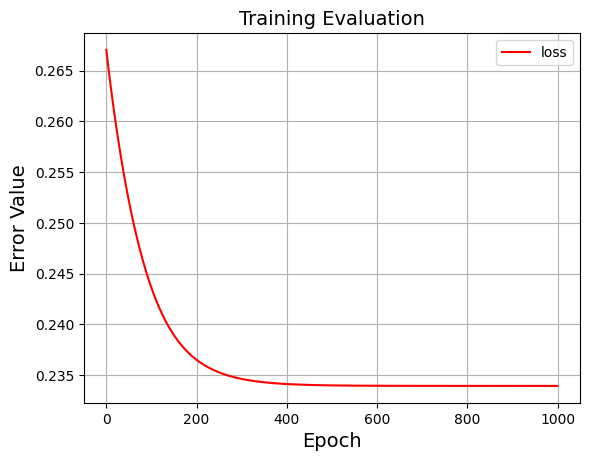

In [11]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [12]:
predictions = model(x)

predictions

tensor([[0.6269, 0.3732],
        [0.6269, 0.3732],
        [0.6269, 0.3732],
        ...,
        [0.6269, 0.3731],
        [0.6269, 0.3732],
        [0.6269, 0.3731]], grad_fn=<SigmoidBackward0>)